In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
from __future__ import print_function

import os.path
import sys
import time

import urllib

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

# Environments

In [2]:

"""
Please note, the environments for the codes.
"""

import platform

print(platform.linux_distribution())

print(platform.python_version())

print(tf.__version__)

print(np.__version__)

('Ubuntu', '14.04', 'trusty')
2.7.6
1.0.1
1.13.1


# Load Data

In [3]:
"""
references:  stanford cs231n assignment2
"""

from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape:         ', X_train.shape)
print('Train labels shape:       ', y_train.shape)
print('Validation data shape:    ', X_val.shape)
print('Validation labels shape:  ', y_val.shape)
print('Test data shape:          ', X_test.shape)
print('Test labels shape:        ', y_test.shape)
print('X_train.dtype:            ', X_train.dtype)
print('y_train.dtype:            ', y_train.dtype)

Train data shape:          (49000, 32, 32, 3)
Train labels shape:        (49000,)
Validation data shape:     (1000, 32, 32, 3)
Validation labels shape:   (1000,)
Test data shape:           (10000, 32, 32, 3)
Test labels shape:         (10000,)
X_train.dtype:             float64
y_train.dtype:             int64


# Visualize Examples

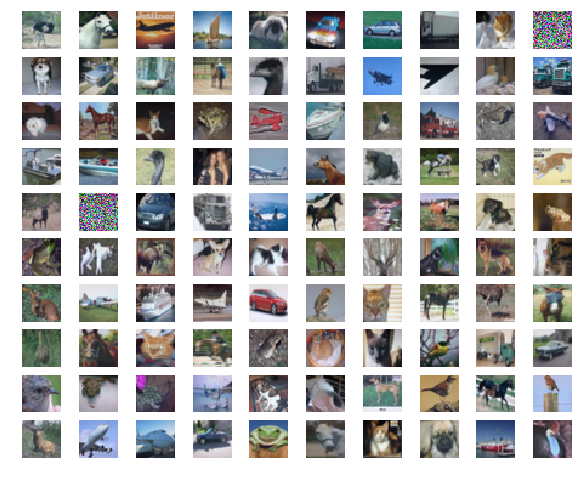

In [4]:
img = X_train[np.random.randint(0, 49000, size = 100), :]
img_max, img_min = np.max(img), np.min(img)
img = 255.0 * (img - img_min) / (img_max - img_min)
img = img.astype('uint8')

    
for i in range(10):
    for j in range(10):
        plt.subplot(10, 10, i * 10 + j + 1)
        plt.imshow(img[i * 10 + j, :])
        plt.gca().axis('off')
        
plt.show()

# Reshape the image into rows

In [4]:
# Preprocessing: reshape the image data into rows
# refer to stanford cs231n assignment1
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

print('Train data shape:         ', X_train.shape)
print('Train labels shape:       ', y_train.shape)
print('Validation data shape:    ', X_val.shape)
print('Validation labels shape:  ', y_val.shape)
print('Test data shape:          ', X_test.shape)
print('Test labels shape:        ', y_test.shape)
print('X_train.dtype:            ', X_train.dtype)
print('y_train.dtype:            ', y_train.dtype)

Train data shape:          (49000, 3072)
Train labels shape:        (49000,)
Validation data shape:     (1000, 3072)
Validation labels shape:   (1000,)
Test data shape:           (10000, 3072)
Test labels shape:         (10000,)
X_train.dtype:             float64
y_train.dtype:             int64


In [5]:
# append the bias dimension of ones 
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

print('Train data shape:         ', X_train.shape)
print('Train labels shape:       ', y_train.shape)
print('Validation data shape:    ', X_val.shape)
print('Validation labels shape:  ', y_val.shape)
print('Test data shape:          ', X_test.shape)
print('Test labels shape:        ', y_test.shape)
print('X_train.dtype:            ', X_train.dtype)
print('y_train.dtype:            ', y_train.dtype)

Train data shape:          (49000, 3073)
Train labels shape:        (49000,)
Validation data shape:     (1000, 3073)
Validation labels shape:   (1000,)
Test data shape:           (10000, 3073)
Test labels shape:         (10000,)
X_train.dtype:             float64
y_train.dtype:             int64


# Model

In [29]:
def weight_variable_reg(shape, stddev, reg):
    var = tf.Variable(tf.truncated_normal(shape, stddev = stddev))
    if reg is not None:
        weight_loss = tf.multiply(tf.nn.l2_loss(var), reg, name = 'weight_loss')
        tf.add_to_collection('losses', weight_loss)
    return var


def one_layer_model(X, weight_size, num_classes, stddev=1e-4, reg=1e-5):
    """
    one_layer_model :
        
    Args:
        X: an input image placeholder 
        
    Returns:
        y_out (logits)
        
    """
    dim0 = weight_size
    shape = [dim0, num_classes]
    
    weight = weight_variable_reg(shape, stddev, reg)
    
    y_out = tf.matmul(X, weight)
    
    return y_out
        
def svm_loss(logits, y):
    """
    Args:
        logits: Logits tensor, float -[batch_size, NUM_CLASSES]
        y     : Labels tensor, int64 -[batch_size],   NOT ONE HOT
        
    Returns:
        loss: Loss tensor of type float    
    """
    
    y = tf.to_int64(y)
        
    loss = tf.losses.hinge_loss(tf.one_hot(y, 10), logits=logits)
    mean_loss = tf.reduce_mean(loss)
    
    return mean_loss    

def ce_loss(logits, y):
    """
    Args:
        logits: Logits tensor, float -[batch_size, NUM_CLASSES]
        y     : Labels tensor, int64 -[batch_size],   NOT ONE HOT
        
    Returns:
        loss: Loss tensor of type float    
    """
    
    y = tf.to_int64(y)
    
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    mean_loss = tf.reduce_mean(loss)
    
    return mean_loss  


def training(loss, learining_rate):
    """
    Sets up the training Ops.
 
    Args:
        loss:          Loss tensor.
        learning_rate: The learning rate to use for gradient descent.
    Returns:
        train_op: The Op for training.
    """

    optimizer = tf.train.GradientDescentOptimizer(learining_rate)
    
    global_step = tf.Variable(0, name = 'global_step', trainable = False)
    
    train_op = optimizer.minimize(loss, global_step = global_step)
    
    return train_op

def evaluation(logits, labels):
    """
    Args:
        logits: Logits tensor, float - [batch_size, NUM_CLASSES]
        labels: labels tensor, int32 - [batch_size], in the range [0, NUM_CLASSES)
    
    Returns:
        A scalar int32 tensor
   
    """
    correct = tf.nn.in_top_k(logits, labels, 1)

    
    return tf.reduce_mean(tf.cast(correct, tf.float32))    

# Graph

In [50]:
class configs:
    weight_size = 3073
    num_classes = 10
    epochs = 5
    batch_size = 256
    learning_rate = 1e-7
    reg = 1.0e4
    print_every = 100
    model_path_name = "./models/svm.ckpt"
    

def placeholder_inputs(batch_size):
    """
    A function to generate placeholder variables for the input tensors
    
    Args:
        batch_size
        
    Returns:
        images_placeholder:  input image placeholder
        labels_placeholder:  input image labels placeholder   
        is_training       :  training or validing
    """
    
    X = tf.placeholder(tf.float32, shape=[batch_size, configs.weight_size])
    y = tf.placeholder(tf.int64, shape=[batch_size])

    return X, y

    
def data_next_batch(indicies, data_set, label_set, i):
    """
    Args:
        indicies:  The shuffled indexes of training data_set 
        data_set:  images from cifar10  
        label_set: labels from cifar10
        i        : the ith batch data
        
    Returns:
        images and labels for feed_dict
       
    """
    start_idx = (i * configs.batch_size) % data_set.shape[0]
    end_idx = np.min([start_idx + configs.batch_size, data_set.shape[0]])
    
    idx = indicies[start_idx : end_idx]
    
    
    return data_set[idx, :], label_set[idx]
 
def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session 
    
def run_training_svm():
    """Train MNIST for a number of steps."""

    with tf.Graph().as_default():
        X, y = placeholder_inputs(None)
        
        y_out = one_layer_model(X, configs.weight_size, configs.num_classes, stddev=1e-4, reg=configs.reg)
        
        accuracy = evaluation(y_out, y)
        
        loss = svm_loss(y_out, y) + tf.get_collection('losses')
        
        train_step = training(loss, configs.learning_rate)
        
        init = tf.global_variables_initializer()
        
        saver = tf.train.Saver()


        sess = get_session()
        sess.run(init)
        
        iter_cnt = 1
        best_val_acc = -1
        for e in range(configs.epochs):
            validing_now = False

            train_indicies = np.arange(X_train.shape[0])
            np.random.shuffle(train_indicies)

            losses = []
            train_accuracies = []    
            for i in range(int(math.ceil(X_train.shape[0] * 1.0 / configs.batch_size))):
                batch_X, batch_y = data_next_batch(train_indicies, X_train, y_train, i)    


                if i % configs.print_every == 0:
                    train_accuracy = sess.run(accuracy, feed_dict = {X: batch_X, y: batch_y})
                    train_accuracies.append(train_accuracy)
                    print('Iter %9d, training batch accuracy %g' % (iter_cnt, train_accuracy))

                _loss, _ = sess.run([loss, train_step], feed_dict={X: batch_X, y: batch_y})
                losses.append(_loss)

                iter_cnt += 1
            
            validing_now = True    
            if validing_now:
                feed_val_dict = {X: X_val, y: y_val}    
                val_loss, val_acc = sess.run([loss, accuracy], feed_dict = feed_val_dict)

                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    saver.save(sess, configs.model_path_name)

            print("Epoch {2}, Overall validation loss = {0}, validation acuracy = {1}".format(val_loss, val_acc, e+1))
            print("Epoch {1}, best validation accuracy = {0}".format(best_val_acc, e+1))
                                                      
            ## visualizing loss and accuracy 
            plt.subplot(2, 1, 1)
            plt.plot(losses)
            plt.grid(True)
            plt.title('Training Loss')
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')

            plt.subplot(2, 1, 2)
            plt.plot(train_accuracies)
            plt.title("Training accuruacy")
            plt.xlabel("look_every number")
            plt.ylabel("correct accuracy")


            plt.show()    
        
    ## load the best model
    saver.restore(sess, configs.model_path_name)
    feed_dict = {X: X_test, y: y_test}
    test_acc = sess.run(accuracy, feed_dict = feed_dict)
        
    print("test set accuracy:   ", test_acc)


    
def run_training_softmax():
    """Train MNIST for a number of steps."""
 
    with tf.Graph().as_default():
        X, y = placeholder_inputs(None)
        
        y_out = one_layer_model(X, configs.weight_size, configs.num_classes, stddev=1e-4, reg=configs.reg)
        
        accuracy = evaluation(y_out, y)
        
        loss = ce_loss(y_out, y) + tf.get_collection('losses')
        
        train_step = training(loss, configs.learning_rate)
        
        init = tf.global_variables_initializer()
        
        saver = tf.train.Saver()


        sess = get_session()
        sess.run(init)
        
        iter_cnt = 1
        best_val_acc = -1
        for e in range(configs.epochs):
            validing_now = False

            train_indicies = np.arange(X_train.shape[0])
            np.random.shuffle(train_indicies)

            losses = []
            train_accuracies = []    
            for i in range(int(math.ceil(X_train.shape[0] * 1.0 / configs.batch_size))):
                batch_X, batch_y = data_next_batch(train_indicies, X_train, y_train, i)    


                if i % configs.print_every == 0:
                    train_accuracy = sess.run(accuracy, feed_dict = {X: batch_X, y: batch_y})
                    train_accuracies.append(train_accuracy)
                    print('Iter %9d, training batch accuracy %g' % (iter_cnt, train_accuracy))

                _loss, _ = sess.run([loss, train_step], feed_dict={X: batch_X, y: batch_y})
                losses.append(_loss)

                iter_cnt += 1
            
            validing_now = True    
            if validing_now:
                feed_val_dict = {X: X_val, y: y_val}    
                val_loss, val_acc = sess.run([loss, accuracy], feed_dict = feed_val_dict)

                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    saver.save(sess, configs.model_path_name)

            print("Epoch {2}, Overall validation loss = {0}, validation acuracy = {1}".format(val_loss, val_acc, e+1))
            print("Epoch {1}, best validation accuracy = {0}".format(best_val_acc, e+1))
                                                      
            ## visualizing loss and accuracy 
            plt.subplot(2, 1, 1)
            plt.plot(losses)
            plt.grid(True)
            plt.title('Training Loss')
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')

            plt.subplot(2, 1, 2)
            plt.plot(train_accuracies)
            plt.title("Training accuruacy")
            plt.xlabel("look_every number")
            plt.ylabel("correct accuracy")


            plt.show()    
        
    ## load the best model
    saver.restore(sess, configs.model_path_name)
    feed_dict = {X: X_test, y: y_test}
    test_acc = sess.run(accuracy, feed_dict = feed_dict)
        
    print("test set accuracy:   ", test_acc)

    

# Training

Iter         1, training batch accuracy 0.0898438
Iter       101, training batch accuracy 0.234375
Epoch 1, Overall validation loss = [ 1.74209523  1.86466038], validation acuracy = 0.288999974728
Epoch 1, best validation accuracy = 0.288999974728


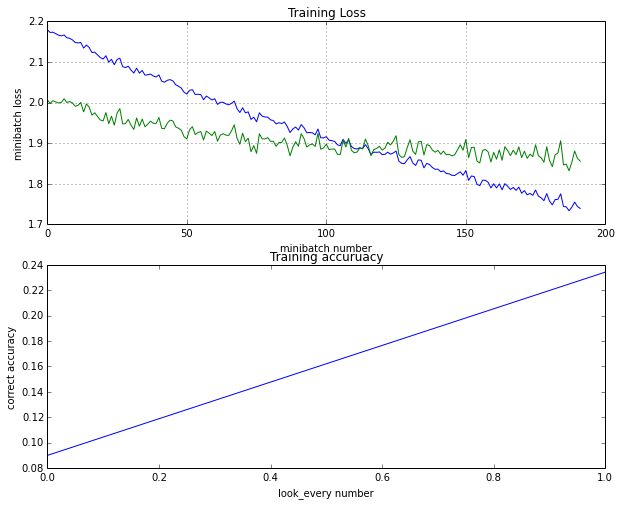

Iter       193, training batch accuracy 0.300781
Iter       293, training batch accuracy 0.289062
Epoch 2, Overall validation loss = [ 1.48062658  1.83642364], validation acuracy = 0.333999991417
Epoch 2, best validation accuracy = 0.333999991417


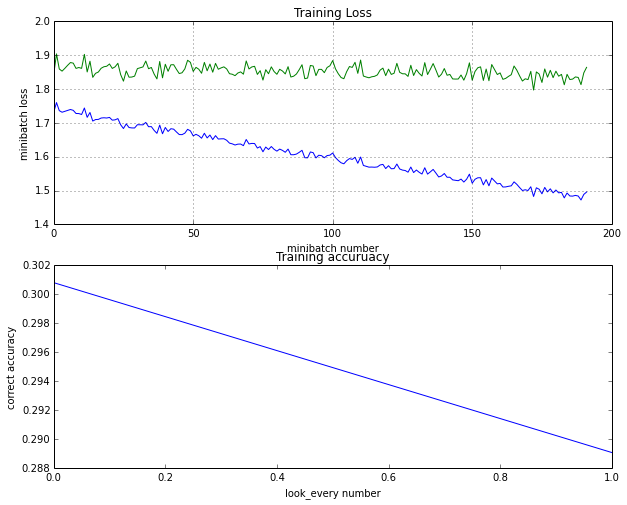

Iter       385, training batch accuracy 0.351562
Iter       485, training batch accuracy 0.28125
Epoch 3, Overall validation loss = [ 1.30811024  1.8272711 ], validation acuracy = 0.347999989986
Epoch 3, best validation accuracy = 0.347999989986


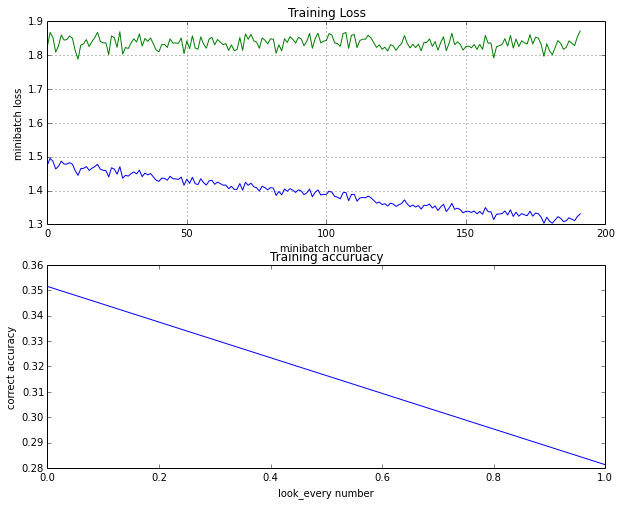

Iter       577, training batch accuracy 0.324219
Iter       677, training batch accuracy 0.347656
Epoch 4, Overall validation loss = [ 1.19161069  1.82183909], validation acuracy = 0.349000036716
Epoch 4, best validation accuracy = 0.349000036716


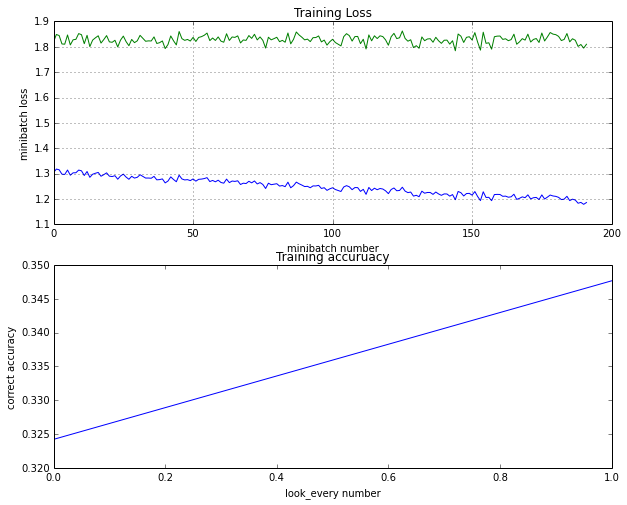

Iter       769, training batch accuracy 0.328125
Iter       869, training batch accuracy 0.300781
Epoch 5, Overall validation loss = [ 1.11273825  1.81849039], validation acuracy = 0.35900002718
Epoch 5, best validation accuracy = 0.35900002718


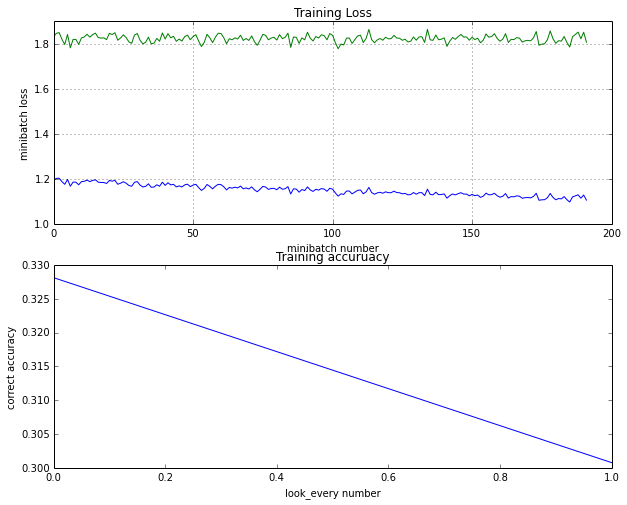

test set accuracy:    0.356


In [49]:
run_training_svm()

Iter         1, training batch accuracy 0.0859375
Iter       101, training batch accuracy 0.289062
Epoch 1, Overall validation loss = [ 2.8252244], validation acuracy = 0.310000002384
Epoch 1, best validation accuracy = 0.310000002384


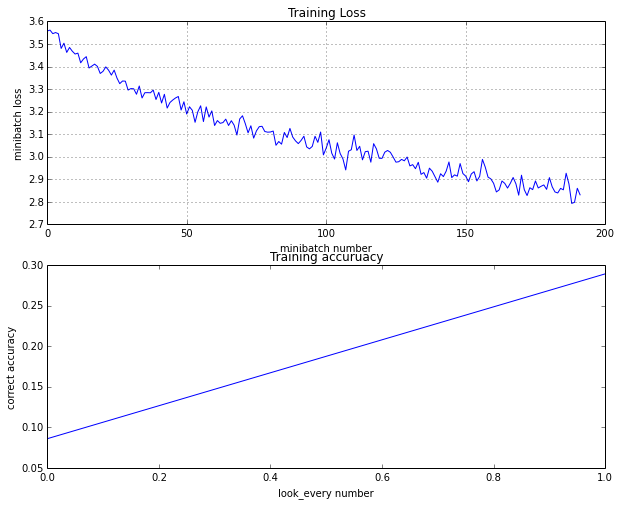

Iter       193, training batch accuracy 0.3125
Iter       293, training batch accuracy 0.324219
Epoch 2, Overall validation loss = [ 2.52508378], validation acuracy = 0.337999999523
Epoch 2, best validation accuracy = 0.337999999523


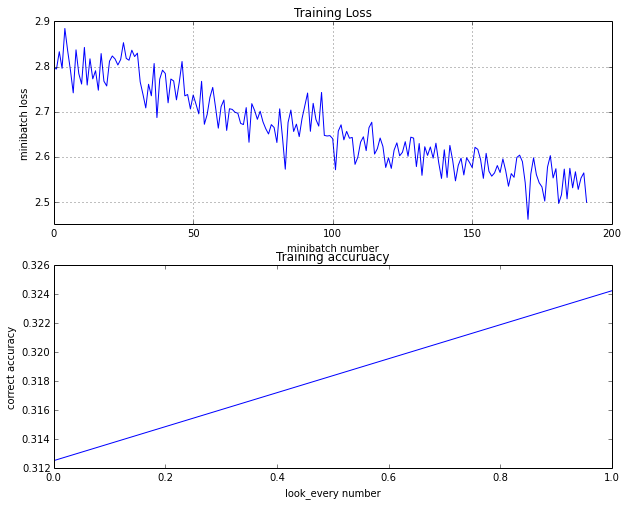

Iter       385, training batch accuracy 0.34375
Iter       485, training batch accuracy 0.351562
Epoch 3, Overall validation loss = [ 2.33482313], validation acuracy = 0.354000002146
Epoch 3, best validation accuracy = 0.354000002146


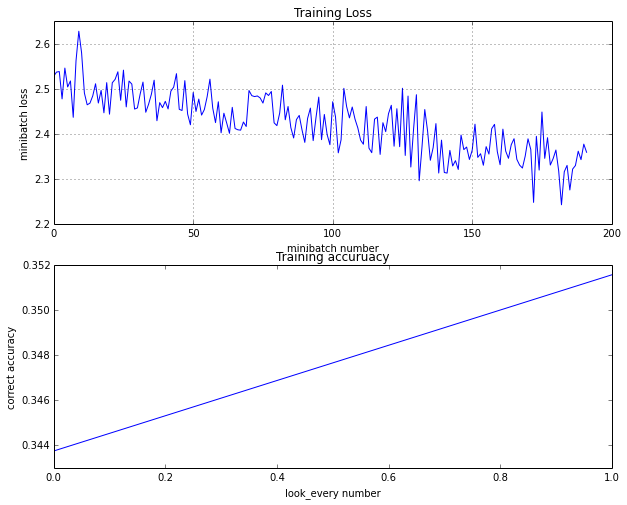

Iter       577, training batch accuracy 0.289062
Iter       677, training batch accuracy 0.367188
Epoch 4, Overall validation loss = [ 2.21061254], validation acuracy = 0.375
Epoch 4, best validation accuracy = 0.375


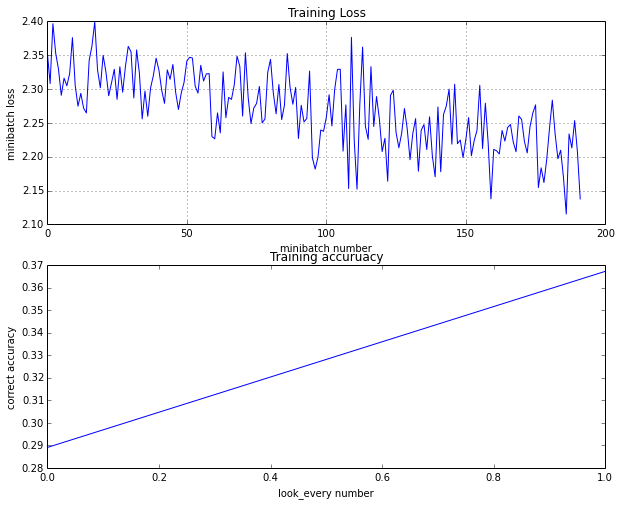

Iter       769, training batch accuracy 0.292969
Iter       869, training batch accuracy 0.359375
Epoch 5, Overall validation loss = [ 2.12772679], validation acuracy = 0.375999987125
Epoch 5, best validation accuracy = 0.375999987125


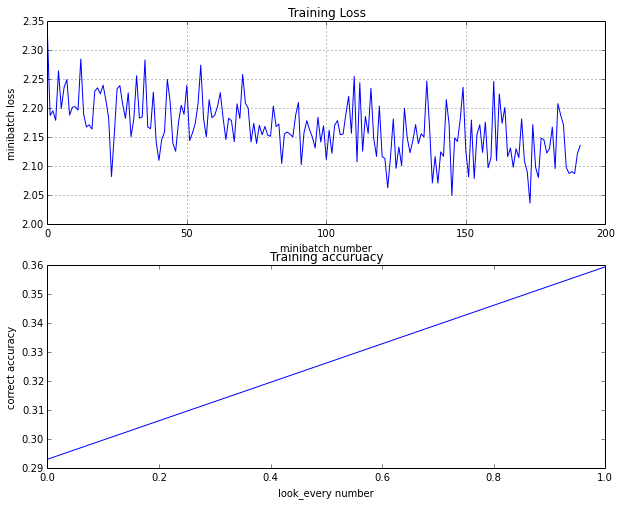

test set accuracy:    0.3623


In [51]:
run_training_softmax()